In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("ventas_por_producto.csv")
display(df.columns)

print("REALIZANDO LOS CAMPOS CALCULADOS...")
# Cantidad promedio de compra
df['cantidad_promedio_compra'] = df['total_cantidad'] / df['total_transacciones']

# Frecuencia de compra (transacciones totales por producto)
df['frecuencia_compra'] = df['total_transacciones']

# O frecuencia mensual (si quieres normalizarla)
df['frecuencia_compra_mensual'] = df['total_transacciones'] / df['mes'].nunique()

display(df.head(3))


print("ELIMINANDO LAS COLUMNAS INNECESARIAS...")
cols_drop = [
    'id_venta',
    'id_cliente',
    'fecha',
    'mes',
    'nombre_producto_venta',
    'nombre_producto_producto',
    'precio_unitario_venta',
    'rotacion_dias',
    'rotacion_promedio',
]
df_clean = df.drop(columns=cols_drop)


dummy_cols = [
    'ciudad_Alta Gracia', 'ciudad_Carlos Paz', 'ciudad_Cordoba',
    'ciudad_Mendiolaza', 'ciudad_Rio Cuarto', 'ciudad_Villa Maria',
    'cat_Alimentos', 'cat_Limpieza',
    'medio_pago_efectivo', 'medio_pago_qr',
    'medio_pago_tarjeta', 'medio_pago_transferencia'
]

df_prod = df_clean.groupby('id_producto').agg({
    'cantidad': 'sum',
    'importe': 'sum',
    'precio_unitario_producto': 'mean',
    'total_cantidad': 'max',
    'total_importe': 'max',
    'total_transacciones': 'max',
    **{col: 'sum' for col in dummy_cols}
}).reset_index()

print("CREANDO LA COLUMNA ETIQUETA A PREDECIR...")
umbral = df_prod['total_transacciones'].median()

df_prod['baja_rotacion'] = (df_prod['total_transacciones'] < umbral).astype(int)

print("ELIMINANDO LA COLUMNA QUE PARTICIPA EN EL CALCULO DE LA ETIQUETA...")
df_prod = df_prod.drop(columns=['total_transacciones'])

print("verificando el dataset final...")
display(df_prod.head(3))

Index(['id_venta', 'id_producto', 'nombre_producto_venta', 'cantidad',
       'precio_unitario_venta', 'importe', 'nombre_producto_producto',
       'precio_unitario_producto', 'fecha', 'id_cliente', 'ciudad_Alta Gracia',
       'ciudad_Carlos Paz', 'ciudad_Cordoba', 'ciudad_Mendiolaza',
       'ciudad_Rio Cuarto', 'ciudad_Villa Maria', 'cat_Alimentos',
       'cat_Limpieza', 'medio_pago_efectivo', 'medio_pago_qr',
       'medio_pago_tarjeta', 'medio_pago_transferencia', 'outlier',
       'rotacion_dias', 'mes', 'total_cantidad', 'total_importe',
       'total_transacciones', 'rotacion_promedio'],
      dtype='object')

REALIZANDO LOS CAMPOS CALCULADOS...


,id_venta,id_producto,nombre_producto_venta,cantidad,precio_unitario_venta,importe,nombre_producto_producto,precio_unitario_producto,fecha,id_cliente,...,outlier,rotacion_dias,mes,total_cantidad,total_importe,total_transacciones,rotacion_promedio,cantidad_promedio_compra,frecuencia_compra,frecuencia_compra_mensual
0,57,41,Aceite de Girasol 1L,4,860,3440,Aceite de Girasol 1L,860,2024-01-10,34,...,False,0.0,2024-01,19,16340,6,22.833333,3.166667,6,1.0
1,86,41,Aceite de Girasol 1L,3,860,2580,Aceite de Girasol 1L,860,2024-01-10,40,...,False,0.0,2024-01,19,16340,6,22.833333,3.166667,6,1.0
2,72,41,Aceite de Girasol 1L,4,860,3440,Aceite de Girasol 1L,860,2024-02-17,26,...,False,38.0,2024-02,19,16340,6,22.833333,3.166667,6,1.0


ELIMINANDO LAS COLUMNAS INNECESARIAS...
CREANDO LA COLUMNA ETIQUETA A PREDECIR...
ELIMINANDO LA COLUMNA QUE PARTICIPA EN EL CALCULO DE LA ETIQUETA...
verificando el dataset final...


,id_producto,cantidad,importe,precio_unitario_producto,total_cantidad,total_importe,ciudad_Alta Gracia,ciudad_Carlos Paz,ciudad_Cordoba,ciudad_Mendiolaza,ciudad_Rio Cuarto,ciudad_Villa Maria,cat_Alimentos,cat_Limpieza,medio_pago_efectivo,medio_pago_qr,medio_pago_tarjeta,medio_pago_transferencia,baja_rotacion
0,1,9,21123,2347.0,9,21123,0,0,0,0,2,0,2,0,2,0,0,0,1
1,2,9,44757,4973.0,9,44757,0,0,0,0,3,0,3,0,0,1,2,0,0
2,3,4,19856,4964.0,4,19856,0,0,0,0,1,0,1,0,0,1,0,0,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


X = df_prod.drop(columns=['baja_rotacion', 'total_cantidad', 'total_importe','precio_unitario_producto',"cantidad", "importe",
                        "medio_pago_efectivo", "medio_pago_qr", "medio_pago_tarjeta", "medio_pago_transferencia", 
                        "ciudad_Alta Gracia", "ciudad_Carlos Paz", "ciudad_Cordoba", "ciudad_Mendiolaza", "ciudad_Rio Cuarto", "ciudad_Villa Maria"])
y = df_prod['baja_rotacion']



X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Verificando los datos de inferencia...")
display(X_test.head(3))

logreg = LogisticRegression(
    max_iter=1000,       # evitar errores de convergencia
    solver='lbfgs'       # solver estándar
)

logreg.fit(X_train_scaled, y_train)

y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

resultados = X_test.copy()
resultados['prob_baja_rotacion'] = y_prob
resultados['baja_rotacion_real'] = y_test.values

resultados.head(20)

y_pred = logreg.predict(X_test_scaled)


precision = precision_score(y_test, y_pred)
print("Precision:", precision)



recall = recall_score(y_test, y_pred)
print("Recall:", recall)

resultados = X_test.copy()
resultados['baja_rotacion_real'] = y_test.values
resultados['baja_rotacion_predicha'] = y_pred
resultados['probabilidad_1'] = y_prob   # opcional

resultados.head(25)


Verificando los datos de inferencia...


,id_producto,cat_Alimentos,cat_Limpieza
51,52,0,1
23,24,5,0
81,85,3,0


Precision: 1.0
Recall: 1.0


,id_producto,cat_Alimentos,cat_Limpieza,baja_rotacion_real,baja_rotacion_predicha,probabilidad_1
51,52,0,1,1,1,0.874757
23,24,5,0,0,0,0.025995
81,85,3,0,0,0,0.298522
12,13,6,0,0,0,0.006721
28,29,3,0,0,0,0.291128
45,46,1,0,1,1,0.864282
33,34,4,0,0,0,0.095181
47,48,2,0,1,1,0.619487
78,82,4,0,0,0,0.097839
9,10,5,0,0,0,0.025771


- MATRIZ DE CONFUSION 

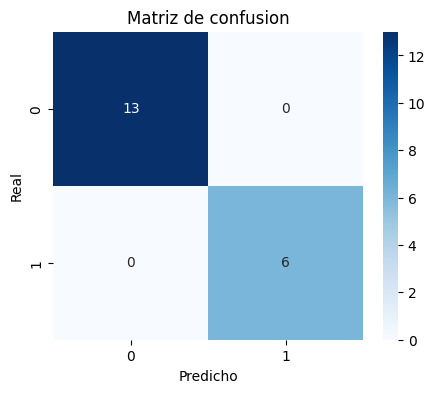

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusion")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


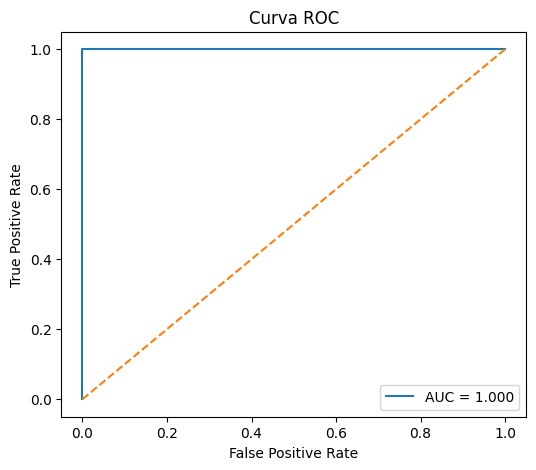

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()


#Metricas
- Accuracy
- Precision
- Recall
- F1-Score
- Matriz de confusión
